In [ ]:
import yfinance as yf
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from math import sqrt
from matplotlib.dates import DateFormatter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

In [ ]:
sp500=yf.Ticker("^GSPC")
US10yr=yf.Ticker("^TNX")

sp500=sp500.history(period='max')
del sp500['Dividends']
del sp500['Stock Splits']
#del sp500['Capital Gains']
del sp500['Volume']
US10yr=US10yr.history(period='max')
US10yr['Close']





Date
1962-01-02 00:00:00-05:00    4.060
1962-01-03 00:00:00-05:00    4.030
1962-01-04 00:00:00-05:00    3.990
1962-01-05 00:00:00-05:00    4.020
1962-01-08 00:00:00-05:00    4.030
                             ...  
2023-11-17 00:00:00-05:00    4.441
2023-11-20 00:00:00-05:00    4.422
2023-11-21 00:00:00-05:00    4.418
2023-11-22 00:00:00-05:00    4.416
2023-11-24 00:00:00-05:00    4.472
Name: Close, Length: 15488, dtype: float64

In [ ]:
sp500['Target']=sp500['Close']-sp500.Open
sp500['US10yr']=US10yr['Close']
sp500['Tomorrow']=sp500['Close'].shift(-1)

sp500['TargetClass']=(sp500['Tomorrow']>sp500['Close']).astype(int)
sp500=sp500.loc['1991-01-01':].copy() # try changing to get better result
#.copy() was used to avoid -pandas settings with copy warning when u subset a dataframe and later assign back to it

#try adding one or two columns to this dataset by adding 10yr bond yield and one more feature
sp500

,Open,High,Low,Close,Target,US10yr,Tomorrow,TargetClass
Date,,,,,,,,
1991-01-02 00:00:00-05:00,0.306061,0.315010,0.300692,0.311431,0.005370,7.970,0.307852,0
1991-01-03 00:00:00-05:00,0.311431,0.316800,0.307852,0.307852,-0.003579,7.930,0.309641,1
1991-01-04 00:00:00-05:00,0.307852,0.316800,0.307852,0.309641,0.001790,8.020,0.309641,0
1991-01-07 00:00:00-05:00,0.307852,0.323960,0.307852,0.309641,0.001790,8.130,0.309641,0
1991-01-08 00:00:00-05:00,0.313221,0.314116,0.304271,0.309641,-0.003579,8.160,0.323960,1
...,...,...,...,...,...,...,...,...
2023-11-17 00:00:00-05:00,190.250000,190.380005,188.570007,189.690002,-0.559998,4.441,191.449997,1
2023-11-20 00:00:00-05:00,189.889999,191.910004,189.880005,191.449997,1.559998,4.422,190.639999,0
2023-11-21 00:00:00-05:00,191.410004,191.520004,189.740005,190.639999,-0.770004,4.418,191.309998,1


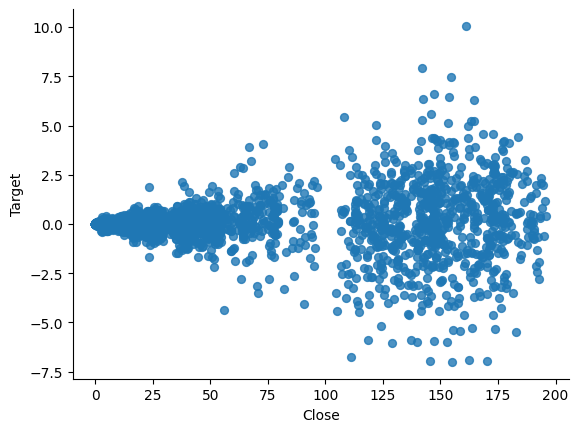

In [ ]:
from matplotlib import pyplot as plt
sp500.plot(kind='scatter', x='Close', y='Target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

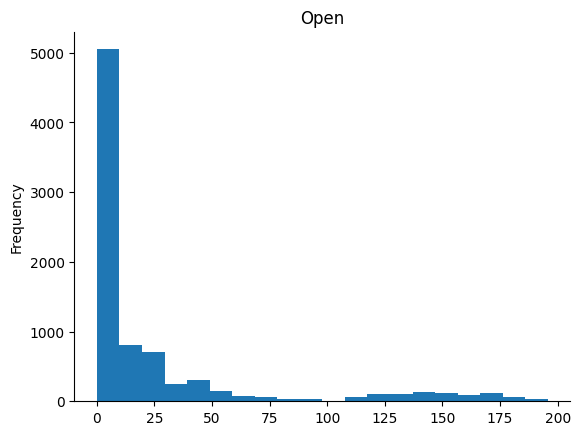

In [ ]:
from matplotlib import pyplot as plt
sp500['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

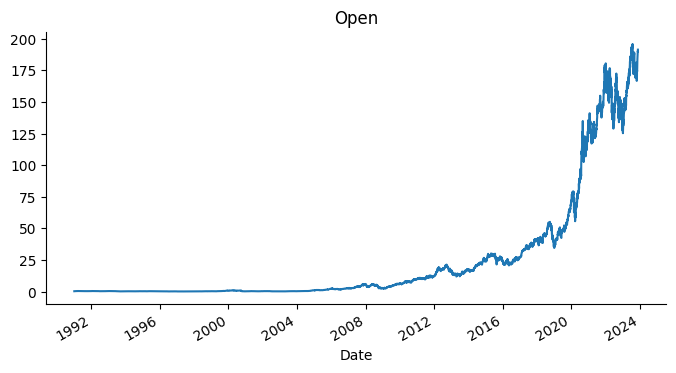

In [ ]:
from matplotlib import pyplot as plt
sp500['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

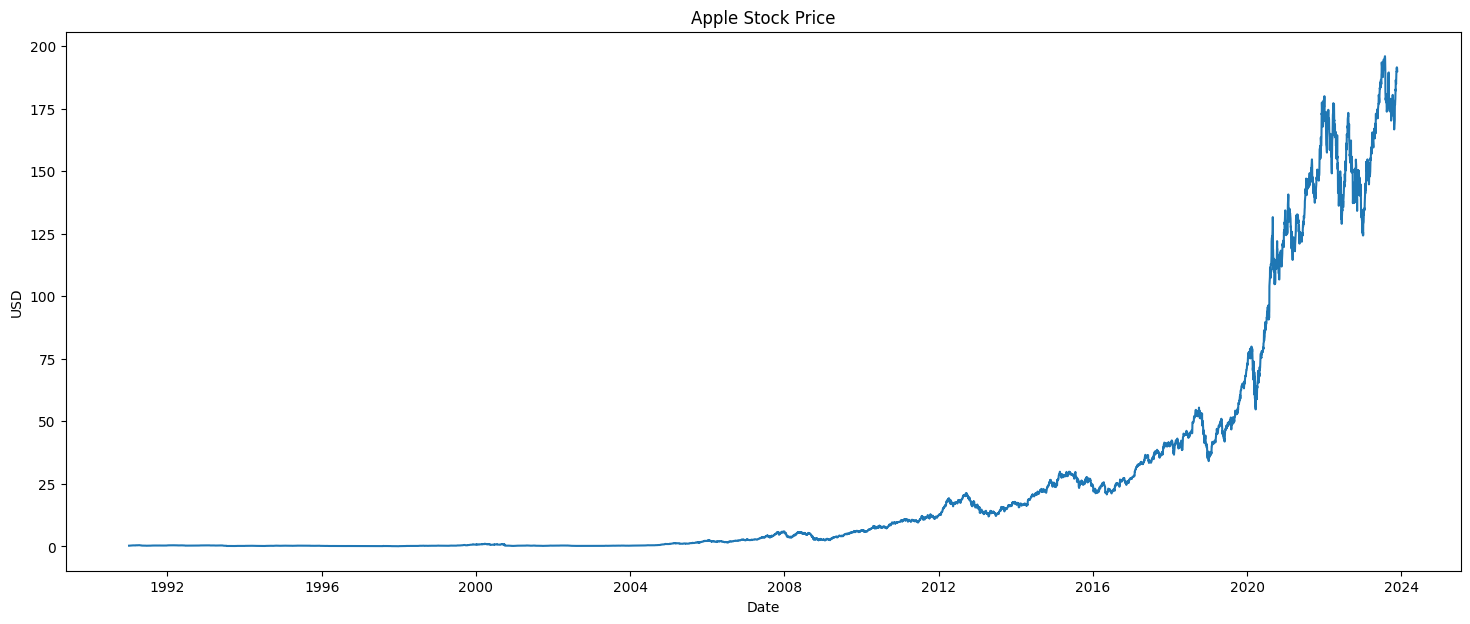

In [ ]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(sp500['Close'], label='Apple stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Apple Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [ ]:
#To calculate indicators
#1 EMA(exponential Moving Average) indicator
sp500['EMA'] = sp500.iloc[:,3].ewm(com=0.5).mean()


'''
An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points
'''
#Calculate moving average
sp500['MA7'] = sp500.iloc[:,3].rolling(window=7).mean()
sp500['MA21'] = sp500.iloc[:,3].rolling(window=21).mean()
#2 MACD indicator
sp500['MACD'] = sp500.iloc[:,3].ewm(span=26).mean() - sp500.iloc[:,1].ewm(span=12,adjust=False).mean()

'''
Moving average convergence/divergence (MACD, or MAC-D) is a trend-following momentum indicator that shows the relationship between
two exponential moving averages (EMAs) of a security’s price.
The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA.
'''
sp500
#10 year bond yield
#Attach all of the above features to the dataset
#interest rate/inflation rate/unemployment rate

,Open,High,Low,Close,Target,US10yr,Tomorrow,TargetClass,EMA,MA7,MA21,MACD
Date,,,,,,,,,,,,
1991-01-02 00:00:00-05:00,0.306061,0.315010,0.300692,0.311431,0.005370,7.970,0.307852,0,0.311431,NaN,NaN,-0.003579
1991-01-03 00:00:00-05:00,0.311431,0.316800,0.307852,0.307852,-0.003579,7.930,0.309641,1,0.308747,NaN,NaN,-0.005713
1991-01-04 00:00:00-05:00,0.307852,0.316800,0.307852,0.309641,0.001790,8.020,0.309641,0,0.309366,NaN,NaN,-0.005922
1991-01-07 00:00:00-05:00,0.307852,0.323960,0.307852,0.309641,0.001790,8.130,0.309641,0,0.309552,NaN,NaN,-0.007208
1991-01-08 00:00:00-05:00,0.313221,0.314116,0.304271,0.309641,-0.003579,8.160,0.323960,1,0.309612,NaN,NaN,-0.006785
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 00:00:00-05:00,190.250000,190.380005,188.570007,189.690002,-0.559998,4.441,191.449997,1,189.454736,186.888572,178.272922,-4.619638
2023-11-20 00:00:00-05:00,189.889999,191.910004,189.880005,191.449997,1.559998,4.422,190.639999,0,190.784910,188.214286,179.168039,-4.853073
2023-11-21 00:00:00-05:00,191.410004,191.520004,189.740005,190.639999,-0.770004,4.418,191.309998,1,190.688303,188.820001,180.018878,-4.985899


8288


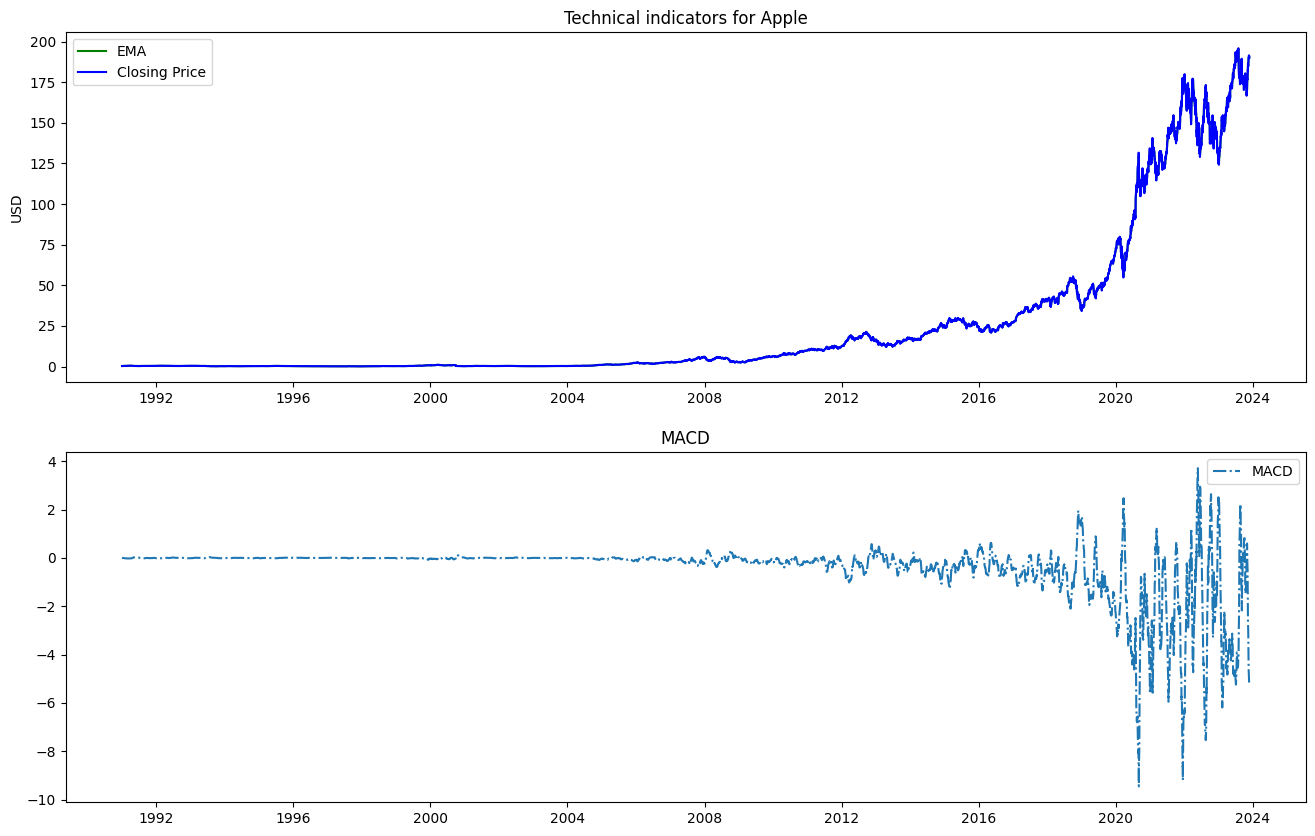

In [ ]:
plt.figure(figsize=(16, 10), dpi=100)
x_ = range(3, sp500.shape[0])

x_ = list(sp500.index)
shape_0=sp500.shape[0]
print(shape_0)
#plotting results
plt.subplot(2, 1, 1)
#plt.plot(sp500['MA7'], label='MA 7', color='g', linestyle='--')
plt.plot(sp500['EMA'], label='EMA', color='g', linestyle='-')

plt.plot(sp500['Close'], label='Closing Price', color='b')
#plt.plot(sp500['MA21'], label='MA 21', color='r', linestyle='--')

plt.title('Technical indicators for Apple')
plt.ylabel('USD')
plt.legend()

# Plot second subplot
plt.subplot(2, 1, 2)
plt.title('MACD')
plt.plot(sp500['MACD'], label='MACD', linestyle='-.')

plt.legend()
plt.show()

In [ ]:
#to get training data
#data=sp500.filter(['Close']) # add US 10yr and one more feature
new_cols = ["Open","High","Low","Close","Target","US10yr","EMA","MA21","MACD","MA7","Tomorrow","TargetClass"]
#df=df[new_cols]
# Or
sp500=sp500.reindex(columns=new_cols)

data=sp500.iloc[:,3:6]


dataset=data.values
print(len(dataset))
#training_dataset_length=math.ceil(len(dataset)*0.8)
#print(training_dataset_length)
#Scale data

dataset=data.values
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
dataset.shape

8288


(8288, 3)

In [ ]:
#spliting the dataset into x_train and y_train dataset
#train_data=scaled_data[0:training_dataset_length]
#print(len(train_data))
x_train=[]
y_train=[]
x=[]
y=[]
#Creating data stucture with 30 timesteps and 1 output.
#30 timesteps meaning storing trends from 30 days before current day to predict 1 next output
#try changing timesteps
for j in range(3):
  x.append([])
  for i in range(30,scaled_data.shape[0]):
    x[j].append(scaled_data[i-30:i,j])
    #y[j].append(train_data[i,0])
x=np.moveaxis(x, [0], [2])
x, yi =np.array(x), np.array(scaled_data[30:,0])
y=np.reshape(yi,(len(yi),1))
#y_train.append(train_data[30:len(train_data),0])
#convert to numpy array
x=np.array(x)
y=np.array(y)
print(x.shape)
print(y.shape)



(8258, 30, 3)
(8258, 1)


In [ ]:
from re import X
#reshaping the dataset as LSTM expects the input in 3dimensional form -no. of samples, no.of time steps and number of features
#x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],10)) #here the feature is 1- only thr closing price,
#see how you can add multiple features here only


In [ ]:
#create test dataset
#test_data=scaled_data[training_dataset_length-30:]
#print(test_data)
x_test=[]
y_test=[]

'''y_test=dataset[training_dataset_length:,:]
for i in range(30,len(test_data)):
  x_test.append(test_data[i-30:i,0])

#convert to numpy array
x_test=np.array(x_test)
print(x_test.shape,y_test.shape)'''
#x_test=np.array(x_test)
#x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#yi =np.array(scaled_data[30:,-6])
#y=np.reshape(yi,(len(yi),1))

#Spliting dataset
splitlimit_x = int(len(x)*0.8)
splitlimit_y=int(len(y)*0.8)

print(splitlimit_x,splitlimit_y)
x_train,x_test=x[:splitlimit_x],x[splitlimit_x:]
y_train,y_test=y[:splitlimit_y],y[splitlimit_y:]


6606 6606


In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],3))
#x_test=np.reshape(x_test, (1,x_test.shape[0],1))
input_dim=x_train.shape[1]
print(input_dim)

30


Epoch 1/10
207/207 - 13s - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0102 - val_accuracy: 6.0533e-04 - 13s/epoch - 63ms/step
Epoch 2/10
207/207 - 6s - loss: 6.2066e-05 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 6.0533e-04 - 6s/epoch - 29ms/step
Epoch 3/10
207/207 - 11s - loss: 6.2295e-05 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 6.0533e-04 - 11s/epoch - 53ms/step
Epoch 4/10
207/207 - 6s - loss: 6.5344e-05 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 6.0533e-04 - 6s/epoch - 27ms/step
Epoch 5/10
207/207 - 8s - loss: 6.8040e-05 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 6.0533e-04 - 8s/epoch - 39ms/step
Epoch 6/10
207/207 - 6s - loss: 6.8845e-05 - accuracy: 0.0000e+00 - val_loss: 0.0115 - val_accuracy: 6.0533e-04 - 6s/epoch - 27ms/step
Epoch 7/10
207/207 - 8s - loss: 6.7884e-05 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 6.0533e-04 - 8s/epoch - 39ms/step
Epoch 8/10
207/207 - 6s - loss: 6.7189e-05 - accuracy: 

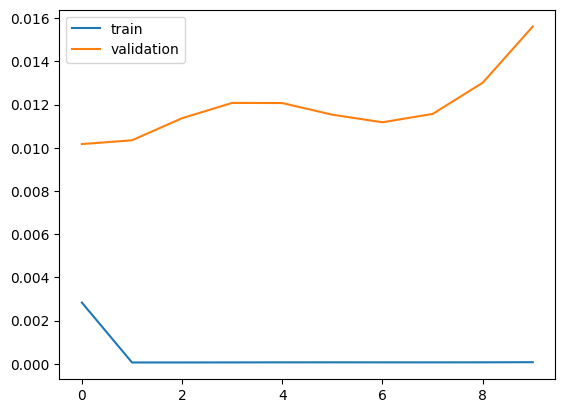

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               34304     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 42625 (166.50 KB)
Trainable params: 42625 (166.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
0.12497367760962633


In [ ]:
#The main thing begins here
#Building a model starts here!
#Parameters
LR = 0.001
BATCH_SIZE = 32
N_EPOCH = 10

input_dim = x_train.shape[1]
feature_size = 2#check and improve
output_dim = 1

def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 64), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(learning_rate=0.001),metrics=['accuracy'], loss='mse')
    history = model.fit(x_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(x_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model
model = basic_lstm(input_dim, feature_size)
#model.save('LSTM_3to1.h5')
print(model.summary())

yhat = model.predict(x_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

In [ ]:
#Create Model number 2
input_dim=x_train.shape[1]

model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(input_dim,3)))
#add dropout
model.add(Dropout(0.1))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Dense(1))
#see if u can add an activation function
model.compile(optimizer=Adam(learning_rate=0.001,clipnorm=1),metrics=['accuracy'],loss='mean_squared_error')



In [ ]:
model.fit(x_train,y_train,batch_size=64,epochs=20,validation_data=(x_test,y_test))#decide on epochs

Epoch 1/20
 53/104 [==============>...............] - ETA: 2s - loss: nan - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
'''predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(predictions-y_test)**2)
'''

'predictions=model.predict(x_test)\npredictions=scaler.inverse_transform(predictions)\nrmse=np.sqrt(np.mean(predictions-y_test)**2)\n'

In [ ]:
y_pred = model.predict(x_test)
y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

52/52 [==============================] - 1s 10ms/step
[0] [0.41080964]
[0] [0.44079408]
[0] [0.46516456]
[0] [0.41231592]
[0] [0.40560684]
[0] [0.4312947]
[0] [0.42992002]
[0] [0.40641098]
[0] [0.40421126]
[0] [0.36461718]


In [ ]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
model.save('Stock.h5')

model = load_model('Stock.h5')
scores = model.evaluate(x_test, y_test)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 1s 9ms/step - loss: 0.0099 - accuracy: 6.0533e-04
Test accuracy:  0.060532690258696675 %


In [ ]:
'''# plot
train=data[:splitlimit_y]
valid=data  [splitlimit_y:]
valid['Predictions']=y_pred
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data',fontsize=18)
plt.ylabel('Close price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','val','Predictions'],loc='lower right')
plt.show'''

"# plot\ntrain=data[:splitlimit_y]\nvalid=data  [splitlimit_y:]\nvalid['Predictions']=y_pred\n#visualize the data\nplt.figure(figsize=(16,8))\nplt.title('Model')\nplt.xlabel('Data',fontsize=18)\nplt.ylabel('Close price USD ($)',fontsize=18)\nplt.plot(train['Close'])\nplt.plot(valid[['Close','Predictions']])\nplt.legend(['Train','val','Predictions'],loc='lower right')\nplt.show"

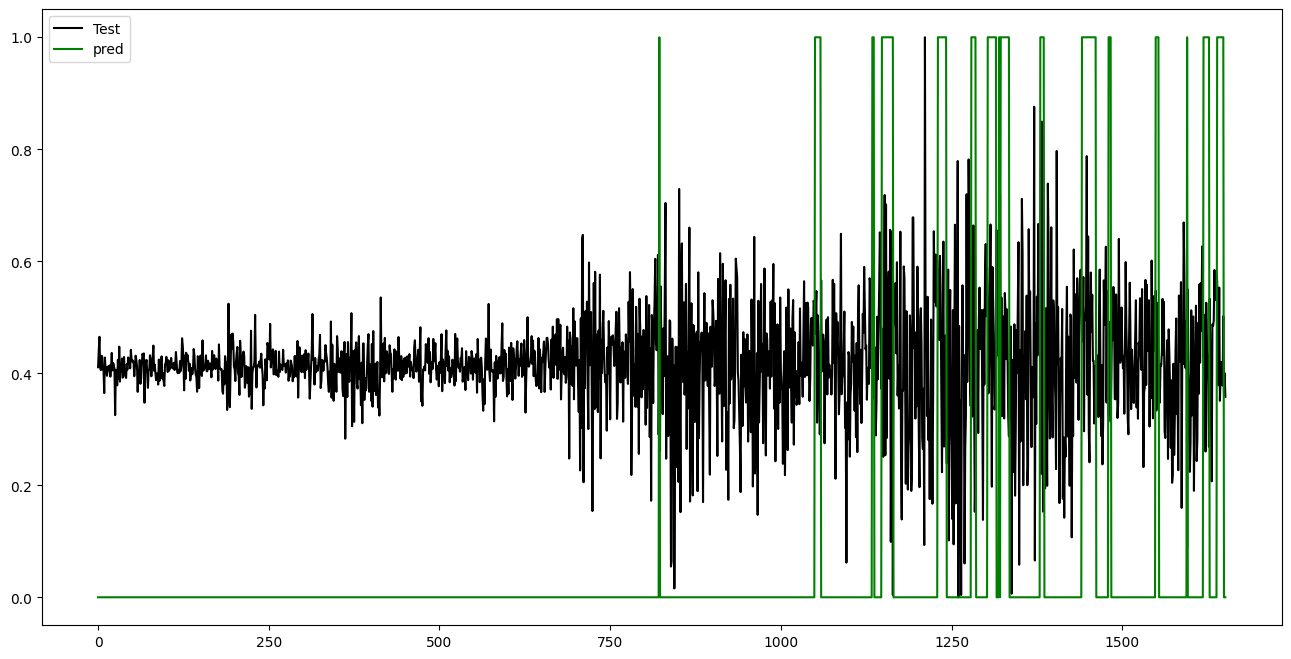

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()